<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Soziale Netzwerke Analysieren Projekt:<br> Raumsonden & Himmelskörper
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Flurina Riner, Patrick Schürmann, Si Ben Tran im HS 2023.<br>Bachelor of Science FHNW in Data Science.
</p>

# 1 Setup & Libraries

Hier in diesem Abschnitt importieren wir die wichtigsten Libraries für unser Projekt.

In [1]:
# Reload modules
%load_ext autoreload
%autoreload 2

# Standard library
from collections import defaultdict

# Data manipulation
import pandas as pd
import numpy as np
import json

# Visualisation
import matplotlib.pyplot as plt

# Network
import networkx as nx

# 2 Explorative Datenanalyse

Bewertungskriterien:   
Explorative Analysen der verwendeten Daten (Missing Values, Verteilungen, Plausilitätsprüfungen), allfällige Transformationen und Bereinigen oder Ausschliessen von fehlerhaften Daten. Wurde  geprüft, ob die Daten mit den Quelldaten übereinstimmen.

## 2.1 Daten einlesen

In [2]:
# Leere Liste für die Episoden
lst_every_episode = []
graph_every_episode = []

# Loop über alle Episoden
for episode in range(1, 8):
    filename = f'data/Star Wars/starwars-episode-{episode}-interactions-allCharacters.json'
    with open(filename, 'r') as file:
        data = json.load(file)

        nodes = data['nodes']

        df_nodes = pd.DataFrame(nodes)
        df_nodes = df_nodes.reset_index(drop=False)
        df_nodes = df_nodes.rename(columns={"index": "ID"})

        edges = data['links']
        df_edges = pd.DataFrame(edges)

        # Liste mit allen Episoden mit Nodes und Edges
        lst_every_episode.append((df_nodes, df_edges))

        # Graph Initialisieren
        G = nx.Graph()

        # Knoten und Kanten hinzufügen
        for idx, row in df_nodes.iterrows():
            G.add_node(row['ID'], label=row['name'], size=row['value'], color=row['colour'])

        for idx, row in df_edges.iterrows():
            G.add_edge(row['source'], row['target'], weight=row['value'])
        
        # Graph speichern
        graph_every_episode.append(G)

## 2.2 Fehlende Werte

## 2.3 Verteilungen der Daten

## 2.4 Plausibilitätsprüfungen

# 3 Netzwerkanalyse der ersten Episode

In [11]:
graph_first_episode = graph_every_episode[0]

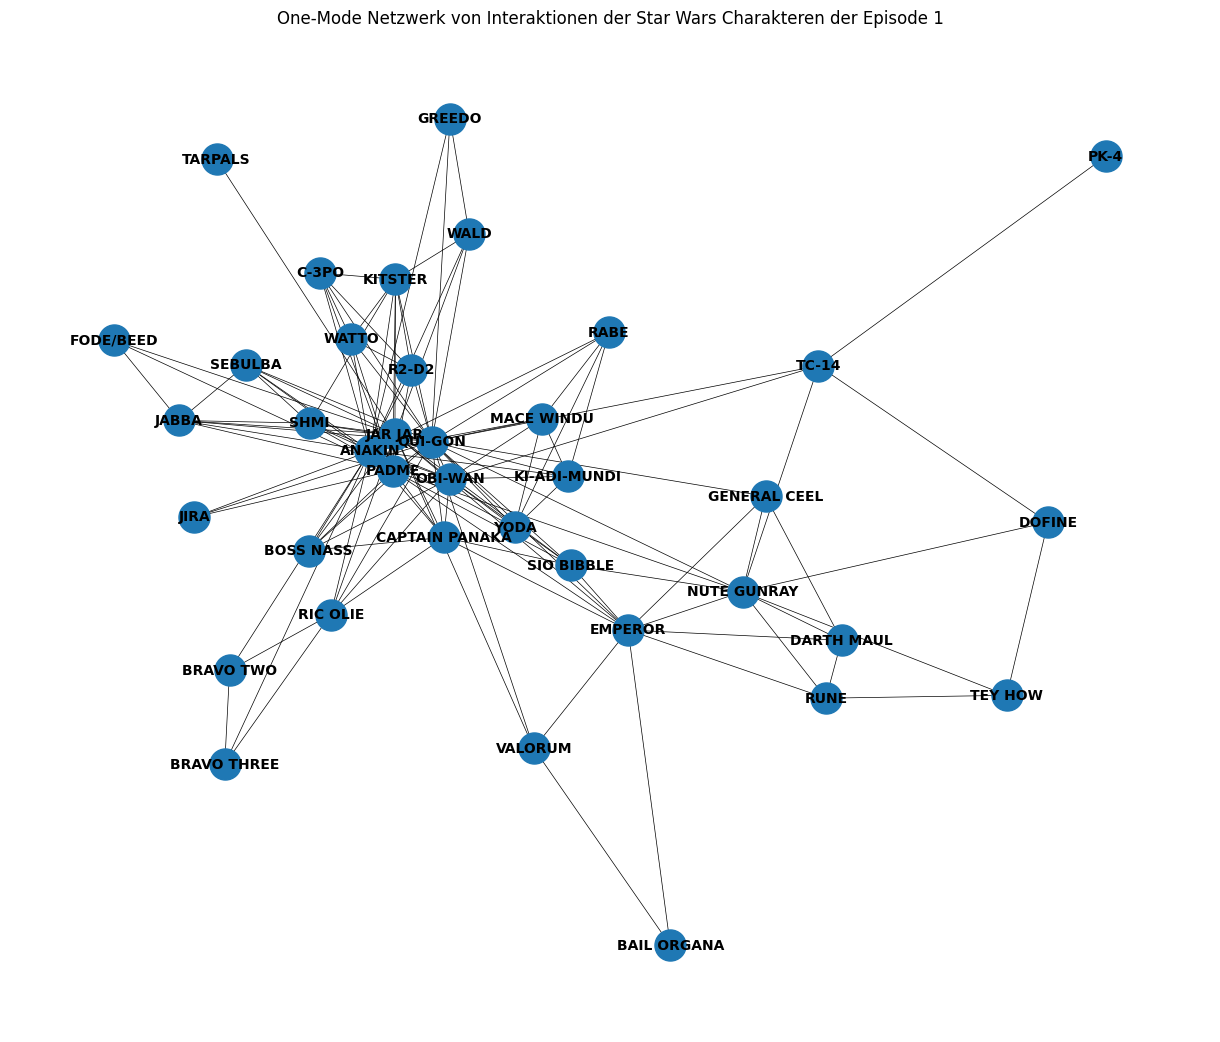

In [12]:
# Labels definieren
labels = {node: data['label'] for node, data in graph_first_episode.nodes(data=True)}

plt.figure(figsize=(12, 10))
# Netzwerkdiagramm zeichnen
nx.draw(graph_first_episode, 
        labels=labels, 
        with_labels=True, 
        node_size=500, 
        edge_color='black', 
        font_size=10, 
        font_weight='bold',
        # alpha=0.5,
        width=0.5,
        pos=nx.spring_layout(graph_first_episode, k=0.1, iterations=20)
       )

plt.title("One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode 1")
plt.show()

## 3.1 Lassen sich Cluster/Communities erkennen oder gar erstellen?

In [26]:
print("Anzahl Connected Components:", nx.number_connected_components(graph_first_episode))

print("Die Komponenten:")
for x in nx.connected_components(graph_first_episode):
    print(x)

Anzahl Connected Components: 1
Die Komponenten:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}


[[0, 1, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37], [2, 35, 4, 3, 6, 7, 8, 23]]


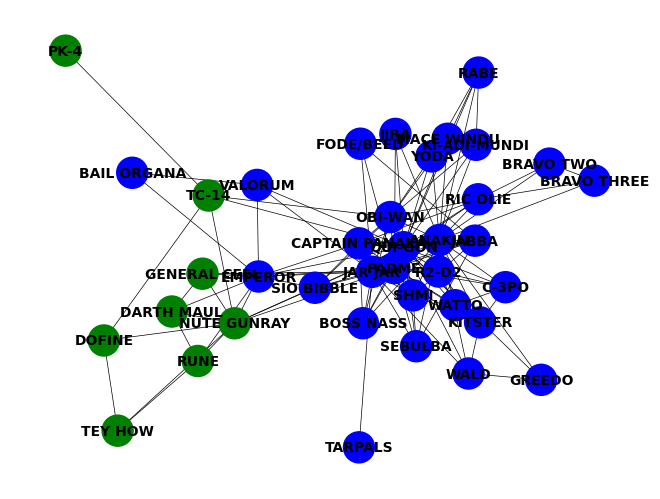

In [61]:
# Idee: Schritt für Schritt plotten (Kante suchen und markieren)

# https://memgraph.com/blog/community-detection-algorithms-with-python-networkx

labels = {node: data['label'] for node, data in graph_first_episode.nodes(data=True)}

communities = nx.community.girvan_newman(graph_first_episode)
 
node_groups = []
for com in next(communities):
  node_groups.append(list(com))
 
print(node_groups)

color_map = []
for node in graph_first_episode:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')


nx.draw(graph_first_episode, 
        labels=labels, 
        with_labels=True, 
        node_color=color_map,
        node_size=500, 
        edge_color='black', 
        font_size=10, 
        font_weight='bold',
        # alpha=0.5,
        width=0.5,
        pos=nx.spring_layout(graph_first_episode, k=0.1, iterations=20)
       )

plt.show()

## 3.2 Gibt es Cliquen?

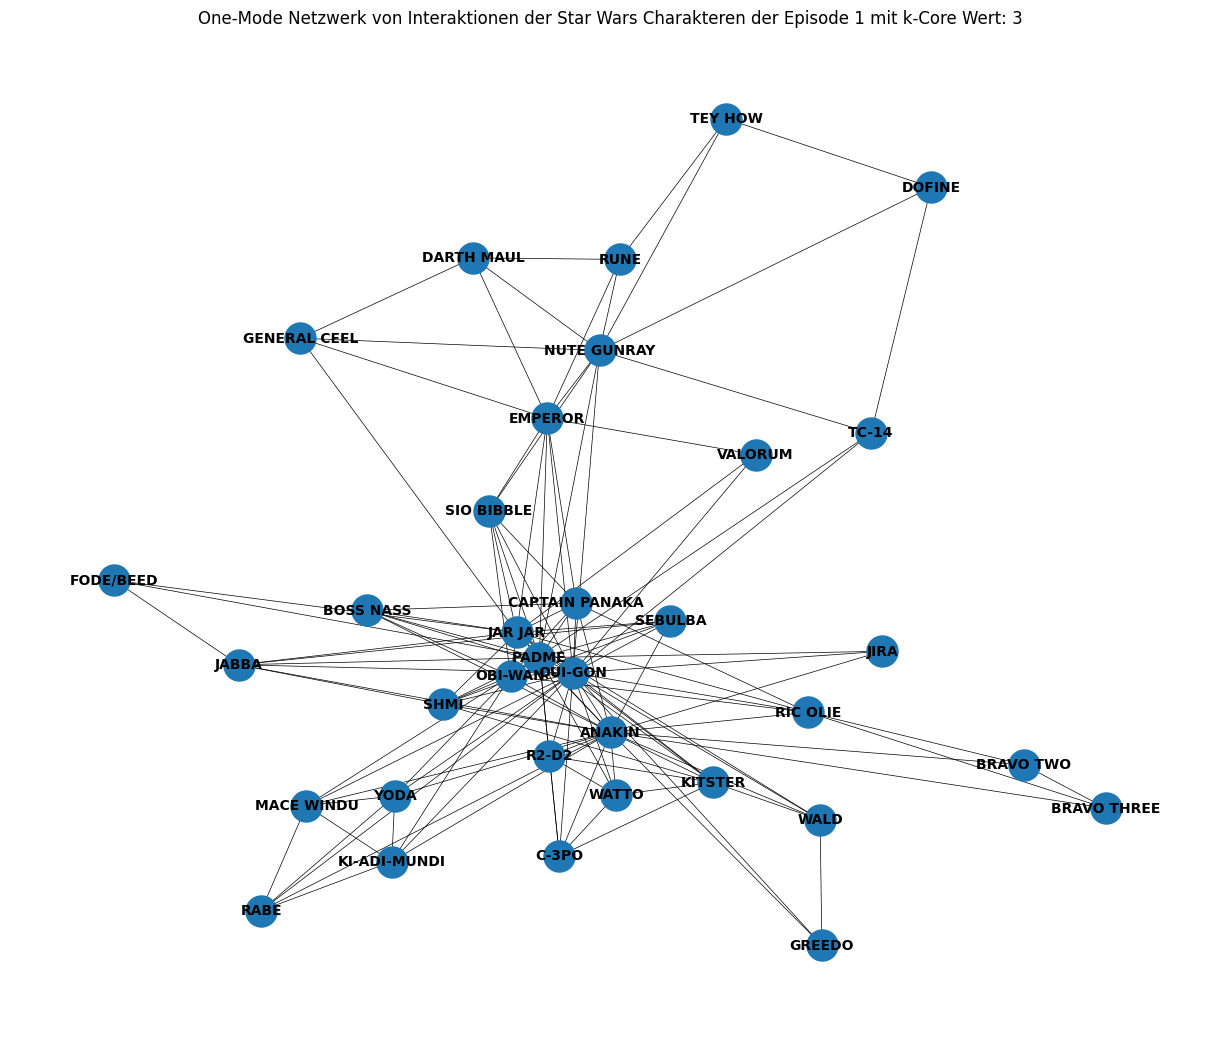

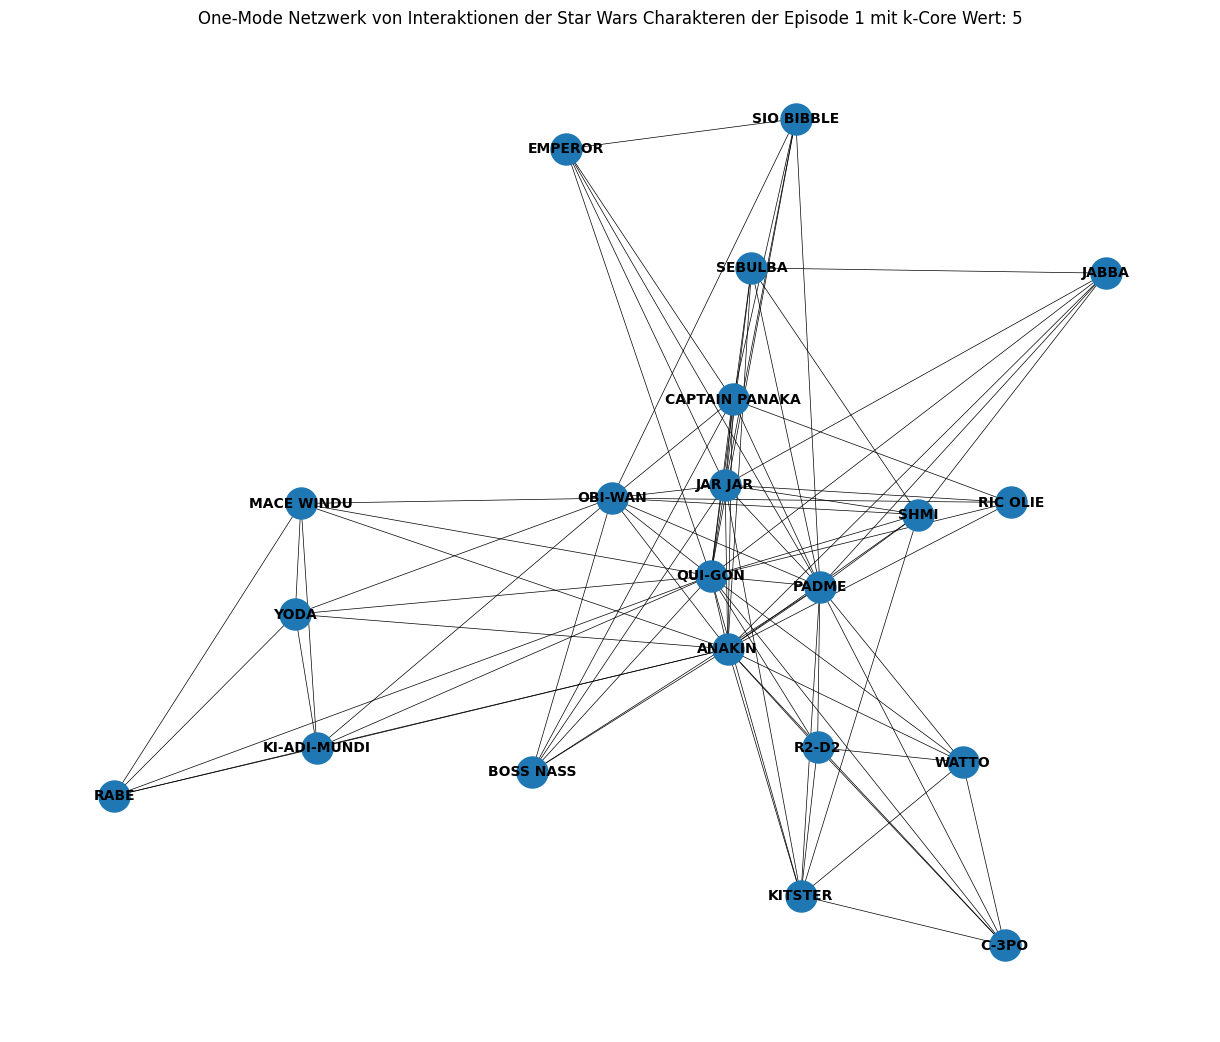

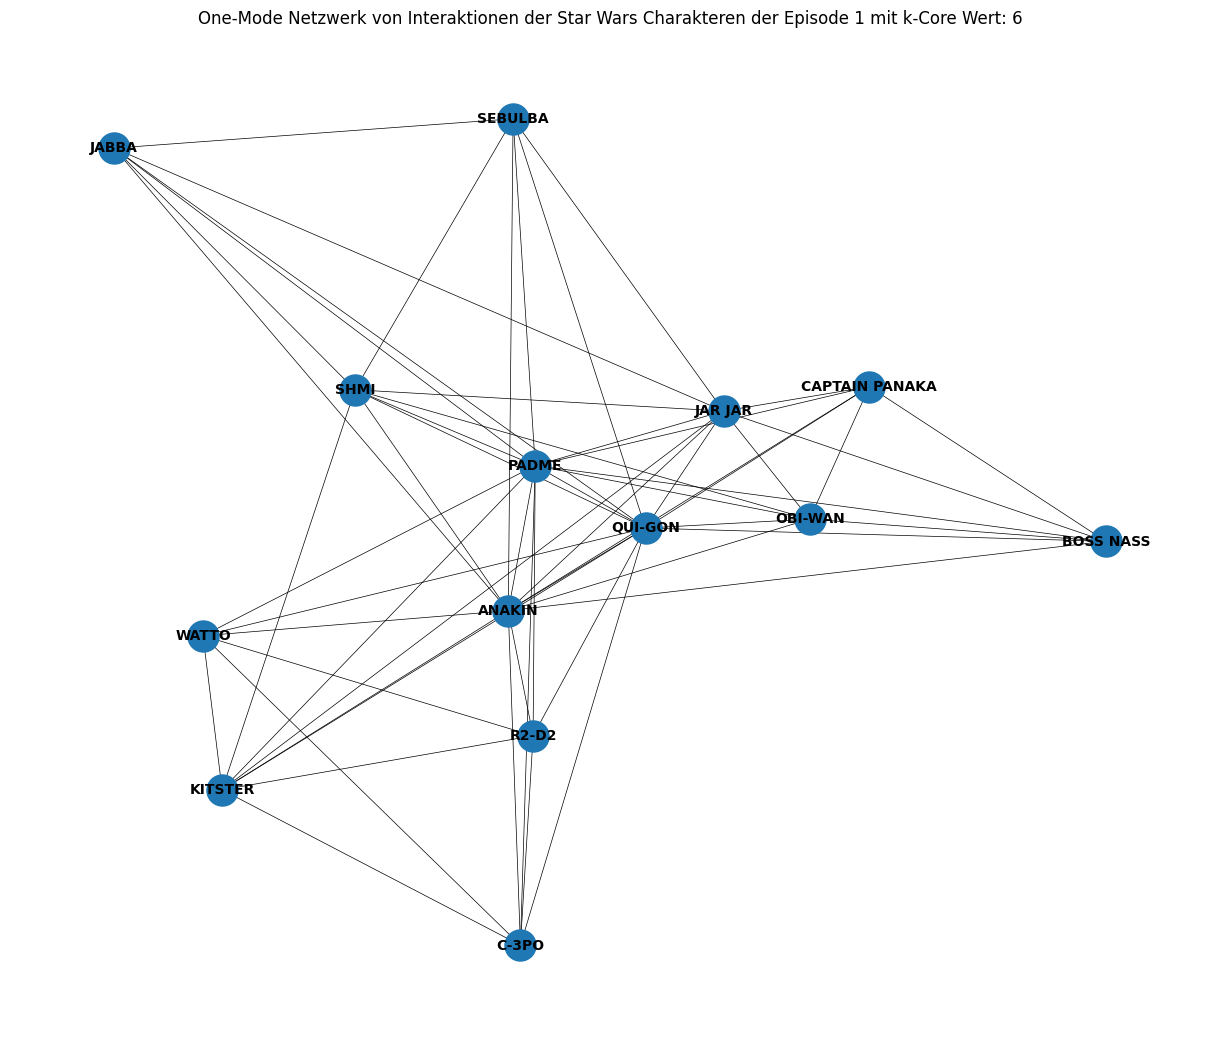

In [45]:
k_numbers = [3, 5, 6]

for k_value in k_numbers:
    k_core_cluster = nx.k_core(graph_first_episode, k=k_value)

    # Labels definieren
    labels = {node: data['label'] for node, data in k_core_cluster.nodes(data=True)}

    plt.figure(figsize=(12, 10))
    # Netzwerkdiagramm zeichnen
    nx.draw(k_core_cluster, 
            labels=labels, 
            with_labels=True, 
            node_size=500, 
            edge_color='black', 
            font_size=10, 
            font_weight='bold',
            # alpha=0.5,
            width=0.5,
            pos=nx.spring_layout(k_core_cluster, k=0.1, iterations=20)
        )
    plt.title(f"One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode 1 mit k-Core Wert: {k_value}")
    plt.show()

## 3.3 Wie schnell würde sich die Geburt Yodas im Netzwerk verbreiten?

In [49]:
nx.diameter(graph_first_episode)

4

Folgend noch die Kontrolle mit dem Diameter in der k-Core Clique mit dem höchsten möglichen k-Wert (k=6):

In [50]:
nx.diameter(nx.k_core(graph_first_episode, k=6))

2

## 3.4 Bridges und k-connectivity

Stabilität des Netzwerks durch Brdiges und k-connectivity

# 4 Netzwerkanalyse der Entwicklungen im Verlauf der Episoden

Überprüfung, welche Charakteren in welchen Filmen vorkommen.

In [63]:
# Degree Aktor Zentralität in jeder Episode
for episode in graph_every_episode:
    degree_dict = nx.degree(episode)
    name_degree_list = [(episode.nodes[node]['label'], degree) for node, degree in degree_dict]
    print(name_degree_list)

[('R2-D2', 6), ('QUI-GON', 26), ('NUTE GUNRAY', 10), ('PK-4', 1), ('TC-14', 5), ('OBI-WAN', 13), ('DOFINE', 3), ('RUNE', 4), ('TEY HOW', 3), ('EMPEROR', 11), ('CAPTAIN PANAKA', 9), ('SIO BIBBLE', 7), ('JAR JAR', 18), ('TARPALS', 1), ('BOSS NASS', 6), ('PADME', 18), ('RIC OLIE', 7), ('WATTO', 6), ('ANAKIN', 23), ('SEBULBA', 6), ('JIRA', 3), ('SHMI', 8), ('C-3PO', 6), ('DARTH MAUL', 4), ('KITSTER', 9), ('WALD', 5), ('FODE/BEED', 3), ('JABBA', 7), ('GREEDO', 3), ('VALORUM', 4), ('MACE WINDU', 6), ('KI-ADI-MUNDI', 6), ('YODA', 6), ('RABE', 5), ('BAIL ORGANA', 2), ('GENERAL CEEL', 4), ('BRAVO TWO', 3), ('BRAVO THREE', 3)]
[('R2-D2', 3), ('CAPTAIN TYPHO', 3), ('EMPEROR', 9), ('SENATOR ASK AAK', 7), ('ORN FREE TAA', 3), ('MACE WINDU', 10), ('YODA', 10), ('KI-ADI-MUNDI', 5), ('BAIL ORGANA', 7), ('JAR JAR', 10), ('OBI-WAN', 18), ('ANAKIN', 21), ('PADME', 17), ('PK-4', 1), ('SIO BIBBLE', 1), ('SOLA', 4), ('JOBAL', 4), ('RUWEE', 4), ('TAUN WE', 4), ('LAMA SU', 2), ('BOBA FETT', 3), ('JANGO FETT',

Wie es scheint, kommen nur R2-D2 und C3PO in allen Episoden vor. Wir werden deshalb die Vergleiche anhand dieser beider Charakteren durchführen.

## 4.1 Wie entwickeln sich die Wichtigkeiten einzelner Charakteren/Gruppen im Verlauf der Filme?

### 4.1.1 Degree-Zentralität

In [79]:
# Degree Aktor Zentralität für R2-D2 und C-3PO
r2d2_degrees = []
c3po_degrees = []

for episode in graph_every_episode:
    degree_dict = dict(nx.degree_centrality(episode))
    
    for node, degree in degree_dict.items():
        character_name = episode.nodes[node]['label']
        if character_name == "R2-D2":
            r2d2_degrees.append(round(degree, 3))
        elif character_name == "C-3PO":
            c3po_degrees.append(round(degree, 3))

# Ausgabe der Listen
print("R2-D2 Degrees:", r2d2_degrees)
print("C-3PO Degrees:", c3po_degrees)

R2-D2 Degrees: [0.162, 0.094, 0.333, 0.429, 0.3, 0.421, 0.115]
C-3PO Degrees: [0.162, 0.188, 0.375, 0.476, 0.5, 0.579, 0.385]


### 4.1.2 Closeness Zentralität

In [69]:
# Closeness Aktor Zentralität für R2-D2 und C-3PO
r2d2_closeness = []
c3po_closeness = []

for episode in graph_every_episode:
    degree_dict = dict(nx.closeness_centrality(episode))
    
    for node, degree in degree_dict.items():
        character_name = episode.nodes[node]['label']
        if character_name == "R2-D2":
            r2d2_closeness.append(round(degree, 3))
        elif character_name == "C-3PO":
            c3po_closeness.append(round(degree, 3))

# Ausgabe der Listen
print("R2-D2 Closeness:", r2d2_closeness)
print("C-3PO Closeness:", c3po_closeness)

R2-D2 Closeness: [0.487, 0.438, 0.58, 0.614, 0.513, 0.594, 0.441]
C-3PO Closeness: [0.487, 0.457, 0.596, 0.635, 0.645, 0.655, 0.542]


### 4.1.3 Betweenness Zentralität

In [71]:
# Betweenness Aktor Zentralität für R2-D2 und C-3PO
r2d2_betweenness = []
c3po_betweenness = []

for episode in graph_every_episode:
    degree_dict = dict(nx.betweenness_centrality(episode))
    
    for node, degree in degree_dict.items():
        character_name = episode.nodes[node]['label']
        if character_name == "R2-D2":
            r2d2_betweenness.append(round(degree, 3))
        elif character_name == "C-3PO":
            c3po_betweenness.append(round(degree, 3))

# Ausgabe der Listen
print("R2-D2 Betweenness:", r2d2_betweenness)
print("C-3PO Betweenness:", c3po_betweenness)

R2-D2 Betweenness: [0.0, 0.0, 0.023, 0.028, 0.0, 0.01, 0.0]
C-3PO Betweenness: [0.0, 0.002, 0.04, 0.041, 0.074, 0.064, 0.023]


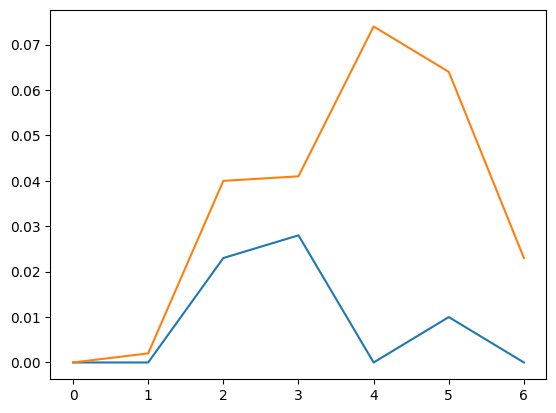

In [73]:
plt.plot(r2d2_betweenness)
plt.plot(c3po_betweenness)

In [75]:
#to-do: - für jede Episode die Person mit dem höchsten Betweenness-Centrality Wert angeben.
#       - Wie gross wäre das Problem im Film, wo R2-D2 verloren ging, gewesen.

# Diskussion: R2-D2 macht zwar wichtige Handlungen (z.B. Millenium Falcon reparieren), aber das sieht man hier bei der Kommunikation nicht. Diese Wichtigkeit kann in dieser Analyse vom sozialen Netzwerk nicht eruiert werden.

Gerne hätten wir auch die Prestige berechnet, da es sich bei unseren Netzwerken um ungerichtete handelt, ist dies leider nicht möglich.

# 5 Entwicklung der Film Netzwerke
## 5.1 Wie entwickeln sich die Zentralisierung der Netzwerke?

Metriken berechnen zu jedem Film und Visualisieren


 

### 5.1.1 Degree Zentralisierung 

### 5.1.2 Closeness 



### 5.1.3 Betweenness Zentralisierung 

## 5.2 Netzwerk Metriken





### 5.2.1 Graph Density



### 5.2.2 Cluster Coefficient 

# 6 Link-Prediction



## 6.1 Jaccard Coefficient


## 6.2 Adamic Adar


## 6.3 Preferential Attachment


## 6.4 Common Neighbors (soundarajan_hopcroft)


## 6.5 Resource Allocation 

# 7 Diffusion 
mal luege was mir da machet

# 8 Hypothesentest

Hypothesentest aufgrund Attributen der Nodes ueber Episoden hinweg

# 9 Ausblick

Sehr wichtig! 